In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import ast
import pandas as pd

def convert_invalid_fields(value):
    if not value:
        return None
    return ast.literal_eval(value)  # Convert string to list

# Read the data
flight_name_1 = Path().cwd().parent / "launch_data" / "genesis_launch_1.csv"
log_buffer_index = 0
data_1 = pd.read_csv(flight_name_1, skiprows=range(1, log_buffer_index), 
                   converters={"invalid_fields": convert_invalid_fields})
flight_name_2 = Path().cwd().parent / "launch_data" / "genesis_launch_2.csv"
data_2 = pd.read_csv(flight_name_2, skiprows=range(1, log_buffer_index), 
                   converters={"invalid_fields": convert_invalid_fields})


Let's first attempt to denoise the data

In [ ]:
# Calculate and plot the jerk of noise in Standby state, for flight 1:

fig1 = plt.figure()
# Extract the data for the Standby state
field = 'scaledAccelZ'
# Remove empty values:
data = data_1.dropna(subset=[field]).copy()
# Take subset of data after no buzz, and before launch:
data = data.iloc[450:3000]  # 450th packet to 3000th packet
# Calculate the jerk:
data['jerk'] = np.gradient(data[field], 1/1000)
# Plot the jerk:
plt.plot(data.index, data['jerk'])
plt.title(f"{field.capitalize()} jerk vs. Index")
plt.xlabel('Index')
plt.ylabel(f"{field.capitalize()} jerk")
plt.show()


In [ ]:
# Find the FFT of the jerk, to see the noise frequency:

# Calculate the FFT of the jerk:
fft = np.fft.fft(data['jerk'])
# Calculate the frequency range:
N = len(data['jerk'])
T = 1/1000
fft_noise_abs_nyquist = np.abs(fft)[:N//2]
fft_noise_freq_nyquist = np.fft.fftfreq(N, T)[:N//2]

# Plot the one-sided fft:
fig1 = plt.figure()
plt.plot(fft_noise_freq_nyquist, fft_noise_abs_nyquist)
plt.title(f"FFT of the noise in StandbyState (jerk of {field})")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [ ]:
# Subtract the noise from the data, and plot the result:

stationary_length = len(data[field])
stationary_fft = np.fft.fft(data[field])
stationary_power = stationary_fft ** 2 / stationary_length
# Get all data for the full flight:
data = data_1.dropna(subset=[field]).copy()
flight_fft = np.fft.fft(data[field])
flight_power = np.abs(flight_fft) ** 2 / len(data[field])


# Subtract the noise from the data:
scaling_factor = len(data[field]) / stationary_length
stationary_power = np.interp(
    np.linspace(0, 1, len(flight_power)), 
    np.linspace(0, 1, len(stationary_power)), 
    stationary_power
)
denoised_power = np.maximum(flight_power - stationary_power, 0)  # Avoid negative values
denoised_fft = np.sqrt(denoised_power) * np.exp(1j * np.angle(flight_fft))  #Recalculate the fft
denoised_signal = np.fft.ifft(denoised_fft).real

scaling_factor = np.max(np.abs(data[field])) / np.max(np.abs(denoised_signal))
denoised_signal *= scaling_factor

# Plot the denoised signal and the original signal:
# Only till row 70000:
plt.plot(data.index, data[field], label='Original signal')
plt.plot(data.index, denoised_signal, label='Denoised signal', alpha=0.7)
plt.title(f"{field} original and denoised vs. Index")
plt.xlim(0, 70000)
plt.grid()
plt.show()

# Only add to rows which have "estCompensatedAccelZ" data:
data_1["estCompensatedAccelZ_denoised"] = np.nan
data_1.loc[data_1["estCompensatedAccelZ"].notnull(), "estCompensatedAccelZ_denoised"] = denoised_signal



In [ ]:
# PLot the accel data for full flight for data_exp

# Drop the rows with empty values:
fig1 = plt.figure()
data_exp = data_1.dropna(subset=['vertical_acceleration']).copy()

plt.plot(data_exp.index, data_exp["vertical_acceleration"], label='Original signal')
plt.xlim(85000, 85900)
plt.ylim(-0, 10)
plt.title(f"vertical_accel vs. Index")
plt.grid()
plt.show()


Now let's actually work with the data

In [ ]:
# Calculate and plot the jerk with the index as x-axis, for flight 1

def plot_data(data, field, jerk, title, T):
    if jerk:
        data['jerk'] = np.gradient(data[field], T)
    data = data.dropna(subset=[field if not jerk else 'jerk']).copy()
    # Plot the jerk:
    fig1 = plt.figure()
    plt.plot(data.index, data[field if not jerk else 'jerk'])
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel(f"{field} {'jerk' if jerk else ''}")
    plt.show()

field = 'estCompensatedAccelZ'
jerk = False
T = 1/500
plot_data(data_1.iloc[:450], field, jerk, f"{field}{' jerk' if jerk else ''} vs. Index", T)


In [ ]:
from scipy.signal import find_peaks

def plot_fft(data, field, jerk, title, plot_peaks=False):
    # Calculate the FFT of the jerk:
    data = data.dropna(subset=[field if not jerk else 'jerk']).copy()
    fft = np.fft.fft(data[field if not jerk else 'jerk'])
    # Calculate the frequency range:
    N = len(data[field if not jerk else 'jerk'])
    fft_abs_nyquist = np.abs(fft)[:N//2]
    fft_freq_nyquist = np.fft.fftfreq(N, T)[:N//2]

    # Find the highest peaks:
    peaks, properties = find_peaks(fft_abs_nyquist, height=0.4*np.max(fft_abs_nyquist))
    top_10_peaks = np.argsort(properties['peak_heights'])[-10:]
    peaks = peaks[top_10_peaks]

    # Plot the one-sided fft:
    fig1 = plt.figure()
    plt.plot(fft_freq_nyquist, fft_abs_nyquist)
    if plot_peaks:
        plt.scatter(
            fft_freq_nyquist[peaks],
            fft_abs_nyquist[peaks],
            color='red',
            label='peaks',
            zorder=5
        )
        for peak_idx in peaks:
            # Put text next to the peak and shift it a bit to the right
            freq = fft_freq_nyquist[peak_idx]
            plt.text(freq, fft_abs_nyquist[peak_idx], f"{freq:.1f} Hz", fontsize=8, ha='right')
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

plot_fft(data_1.iloc[:450], field, jerk, f"FFT of {field}{' jerk' if jerk else ''}", plot_peaks=True)


In [ ]:
# Let's calculate the jerk for the entire CoastState, for flight 1:
# Get data for the coast state:
coast_state = data[data['state'] == "C"].copy()
# Only include the rows after 0.5 seconds after CoastState, because we want to exclude the 
# retract command in the beginning:
coast_state = coast_state[coast_state['timestamp'] > coast_state['timestamp'].iloc[0] + int(0.0*1e9)]
# Only include the first 500 rows, because I want to check if we can isolate the same frequencies
# as in standby state jerk:
# coast_state = coast_state.iloc[:800]

# Plot the jerk:
plot_data(coast_state, field, jerk, f"{field}{' jerk' if jerk else ''} in CoastState vs. Index", T)


In [ ]:
# Now let's do the FFT of the jerk for the coast state:

# Calculate the fft of the jerk:

plot_fft(coast_state, field, jerk, f"FFT of {field}{' jerk' if jerk else ''} in CoastState", plot_peaks=True)


In [ ]:
from scipy.signal import spectrogram

def plot_spectrogram(data, field, title, T, deploy_time=None, nperseg=500, noverlap=300, nfft=1000):
    f, t, Sxx = spectrogram(data[field], fs=1/T, nperseg=nperseg, noverlap=noverlap, nfft=nfft, window="blackman",)
    fig1 = plt.figure()
    plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(title)
    plt.colorbar(label='Power/Frequency [dB/Hz]')
    if deploy_time is not None:
        plt.axvline(x=deploy_time, color="red", linestyle="--",)
        plt.axvline(x=deploy_time + 0.3, color="green", linestyle="--",)
    plt.show()
    return f, t, Sxx

# Perform a time-frequency analysis of the jerk in the coast state:
extend_time_from_coast_beginning = 0.918
f, t, Sxx = plot_spectrogram(coast_state, field, f"Spectrogram of {field} in CoastState", T, deploy_time=extend_time_from_coast_beginning)



In [ ]:
# Extract the power of the frequencies between 150 and 170 Hz:

def plot_band_power(f, Sxx, t, band, title, deploy_time=None):
    band_indices = np.where((f >= band[0]) & (f <= band[1]))[0]
    band_power = np.sum(Sxx[band_indices, :], axis=0)
    fig1 = plt.figure()
    plt.plot(t, band_power)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Power")
    if deploy_time is not None:
        plt.axvline(x=deploy_time, color="red", linestyle="--",)
        plt.axvline(x=deploy_time + 0.3, color="green", linestyle="--",)
    plt.show()

plot_band_power(f, Sxx, t, [150, 170], f"Power of the {field} jerk in the 150-170 Hz band", deploy_time=extend_time_from_coast_beginning)


In [ ]:
# Now do the same for free fall state, we will find the jerk and the fft of the jerk:

free_fall_state = data[data['state'] == "F"].copy()
plot_data(free_fall_state, field, jerk, f"{field}{' jerk' if jerk else ''} in FreeFallState vs. Index", T)


In [ ]:
# Calculate the fft of the jerk:

plot_fft(free_fall_state, field, jerk, f"FFT of {field}{' jerk' if jerk else ''} in free fall")

In [ ]:
# Plot the spectrogram of the jerk in the free fall state:

# Add the last 200 rows of coast state to the free fall state:
coast_state_last_200 = coast_state.iloc[-2000:]
free_fall_state = pd.concat([coast_state_last_200, free_fall_state])

f, t, Sxx =  plot_spectrogram(free_fall_state, field, f"Spectrogram of {field} in FreeFallState", T, nperseg=2048, noverlap=1024, nfft=4096)


In [ ]:
# Extract the power of the frequencies between 150 and 170 Hz:

plot_band_power(f, Sxx, t, [150, 170], f"Power of the {field} jerk in the 150-170 Hz band", deploy_time=1.33)

In [ ]:
# Let's analyze the frequency of the whole flight

full_flight = data.copy()
plot_data(full_flight, field, jerk, f"{field}{' jerk' if jerk else ''} in FullFlight vs. Index", T)

In [ ]:
# Do the FFT of the whole flight:
plot_fft(full_flight, field, jerk, f"FFT of {field}{' jerk' if jerk else ''} in FullFlight", plot_peaks=False)


In [ ]:
# Run the spectrogram for the full flight:

plot_spectrogram(full_flight, field, f"Spectrogram of {field} in FullFlight", T, nperseg=2048, noverlap=1024, nfft=4096)


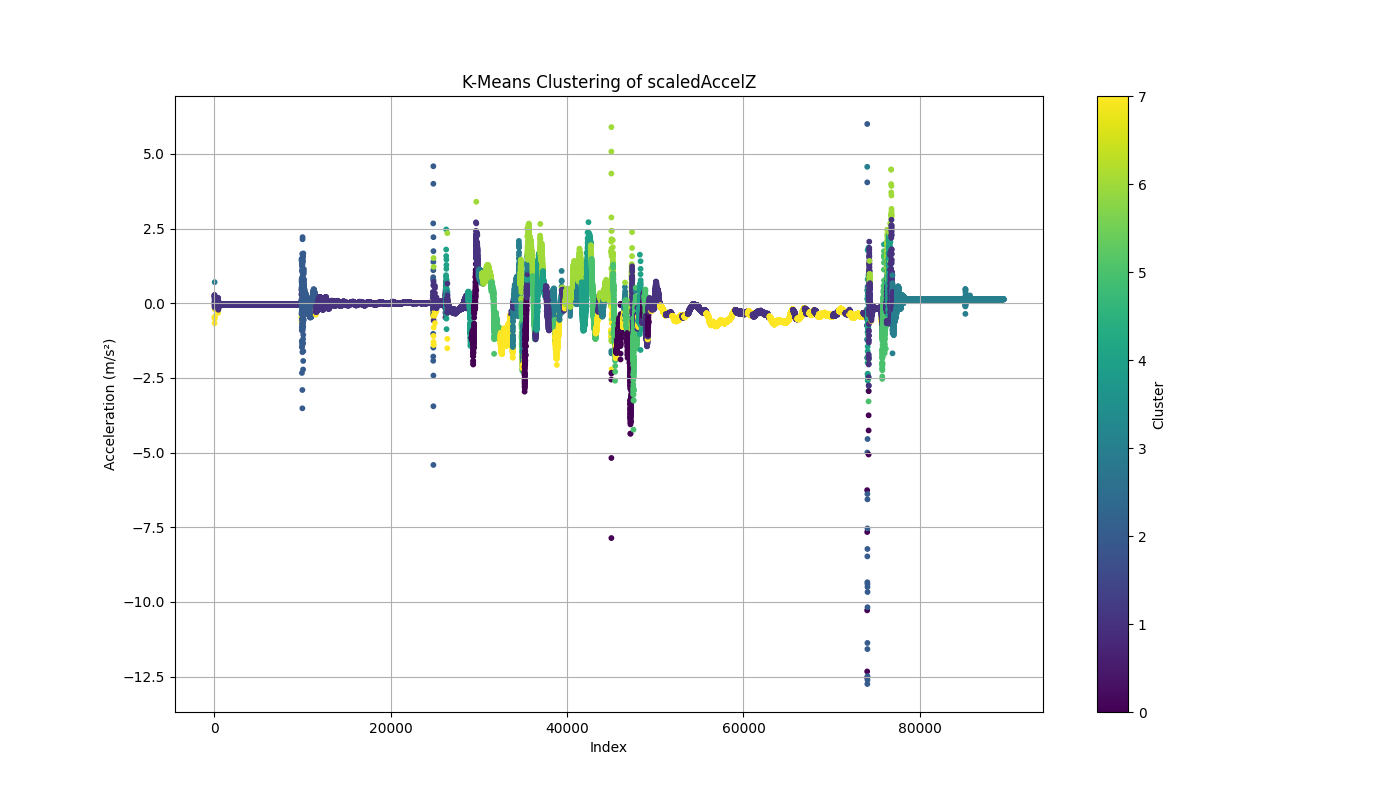

,scaledAccelZ,scaledAccelY,scaledAccelX,scaledGyroZ,scaledGyroY,scaledGyroX
0,-1.186290,0.270010,0.131018,-3.568998,3.549615,3.375688
1,-0.089374,0.101836,-0.466088,0.007248,0.009872,-1.272302
2,-0.110829,0.138785,-9.960764,0.123669,0.031146,-0.451761
3,0.128223,-1.054123,-0.039676,0.172299,0.107060,0.129286
4,0.355501,0.924835,-0.057612,3.607072,1.477016,2.641803
5,-0.503767,-0.094739,-0.257939,0.364958,-4.462476,-1.397473
6,0.904869,-0.156266,0.550151,0.307447,-0.994187,3.585285
7,-0.545499,-0.127770,-0.720892,-0.083432,0.035067,0.492735


In [10]:
# Let's do k-means clustering on the data:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Extract relevant features for clustering
fields = ['scaledAccelZ', 'scaledAccelY', 'scaledAccelX', 'scaledGyroZ', 'scaledGyroY', 'scaledGyroX']
data_filtered = data_1[fields].dropna()  # Drop rows with missing values

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data_filtered[fields])

# Apply K-Means clustering with 6 clusters
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Add cluster labels to the dataset
data_filtered['Cluster'] = clusters

# Plot vertical acceleration with cluster labels
plt.figure(figsize=(14, 8))
plt.scatter(data_filtered.index, data_filtered['scaledAccelZ'], c=data_filtered['Cluster'], cmap='viridis', s=10)
plt.title("K-Means Clustering of scaledAccelZ")
plt.xlabel("Index")
plt.ylabel("Acceleration (m/s²)")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()

# Display cluster centers to understand the patterns
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=fields)
cluster_centers_df


Fourier Analysis of Flight 2:

In [ ]:
# Calculate and plot the vertical_accel, for flight 2, in standby state

# Remove empty values:
field = 'vertical_acceleration'
data = data_2.dropna(subset=[field])

# Calculate the jerk:
data['jerk'] = np.gradient(data[field],0.002)
# print(data['jerk'])

# Plot the jerk:
# plt.plot(data.index, data['jerk'])
# plt.ylim(-750, 750)  # For compensated_accelerationZ jerk
# print(data['estLinearAccelX'])
plt.plot(data.index, data[field])
plt.ylim(9.5, 10.5)  # For vertical_acceleration
# plt.ylim(-11, -9)  # For linear_accelerationX
# plt.ylim(-2, 2)  # For linear_accelerationY
# plt.ylim(-2, 2)  # For linear_accelerationZ

plt.xlim(0, 600)
plt.title(field.capitalize() + ' vs. Index')
plt.xlabel('Index')
plt.ylabel(field)
plt.show()

In [ ]:
# Find the fft and fftfreq of the vertical_acceleration, for flight 2, in standby state:

# Remove empty values:
field = 'vertical_acceleration'
data = data_2.dropna(subset=[field])
vertical_acceleration_centered = data[field] - np.mean(data[field])

# Calculate the fft, for rows 0 to 600:
data = data.iloc[0:500]
# print(data[field])
fft = np.fft.fft(vertical_acceleration_centered)
freq = np.fft.fftfreq(len(vertical_acceleration_centered), d=1/1500)
magnitude = np.abs(fft)
plt.plot(freq[:len(freq) // 2], magnitude[:len(magnitude) // 2])

In [ ]:
# Calculate and plot the jerk with the index as x-axis for landed state, only valid for flight 1:

# Remove empty values:
field = 'vertical_acceleration'
data = data.dropna(subset=[field])

# Calculate the jerk:
data['jerk'] = np.gradient(data[field],0.002)
print(data['jerk'])

# Plot the jerk:
# plt.plot(data.index, data['jerk'])
# plt.ylim(-750, 750)  # For compensated_accelerationZ jerk
# print(data['estLinearAccelX'])
plt.plot(data.index, data[field])
plt.ylim(0.5, 20.5)  # For vertical_acceleration
# plt.ylim(-11, -9)  # For linear_accelerationX
# plt.ylim(-2, 2)  # For linear_accelerationY
# plt.ylim(-2, 2)  # For linear_accelerationZ

data_cutoff = 76000
plt.xlim(80000, 80300)
plt.title(field.capitalize() + ' vs. Index')
plt.xlabel('Index')
plt.ylabel(field)
plt.show()

In [ ]:
def cutoff_data_at_row_and_save_csv(data: pd.DataFrame, row: int, file_name: str):
    data[:row].to_csv(file_name, index=False)

cutoff_data_at_row_and_save_csv(data, data_cutoff, "genesis_launch_1.csv")